In [1]:
from pathlib import Path
from datetime import datetime
from dateutil import tz

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.plots.ctables import registry
from metpy.plots import USCOUNTIES
from metpy.units import units
from siphon.catalog import TDSCatalog
import xarray as xr

In [2]:
# Scan the catalog and download the data

def get_satellite():
    satcat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
                        'CloudAndMoistureImagery/CONUS/Channel10/current/catalog.xml')
    dataset = satcat.datasets[0]
    dataset = dataset.remote_access(use_xarray=True)
    return dataset

ds = get_satellite()

In [3]:
# Parse out the projection data from the satellite file
data = ds.metpy.parse_cf('Sectorized_CMI')
proj = data.metpy.cartopy_crs
x = data['x']
y = data['y']

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

VALID_TIME = convert_datetime(str(data['time'].values).split('.')[0])

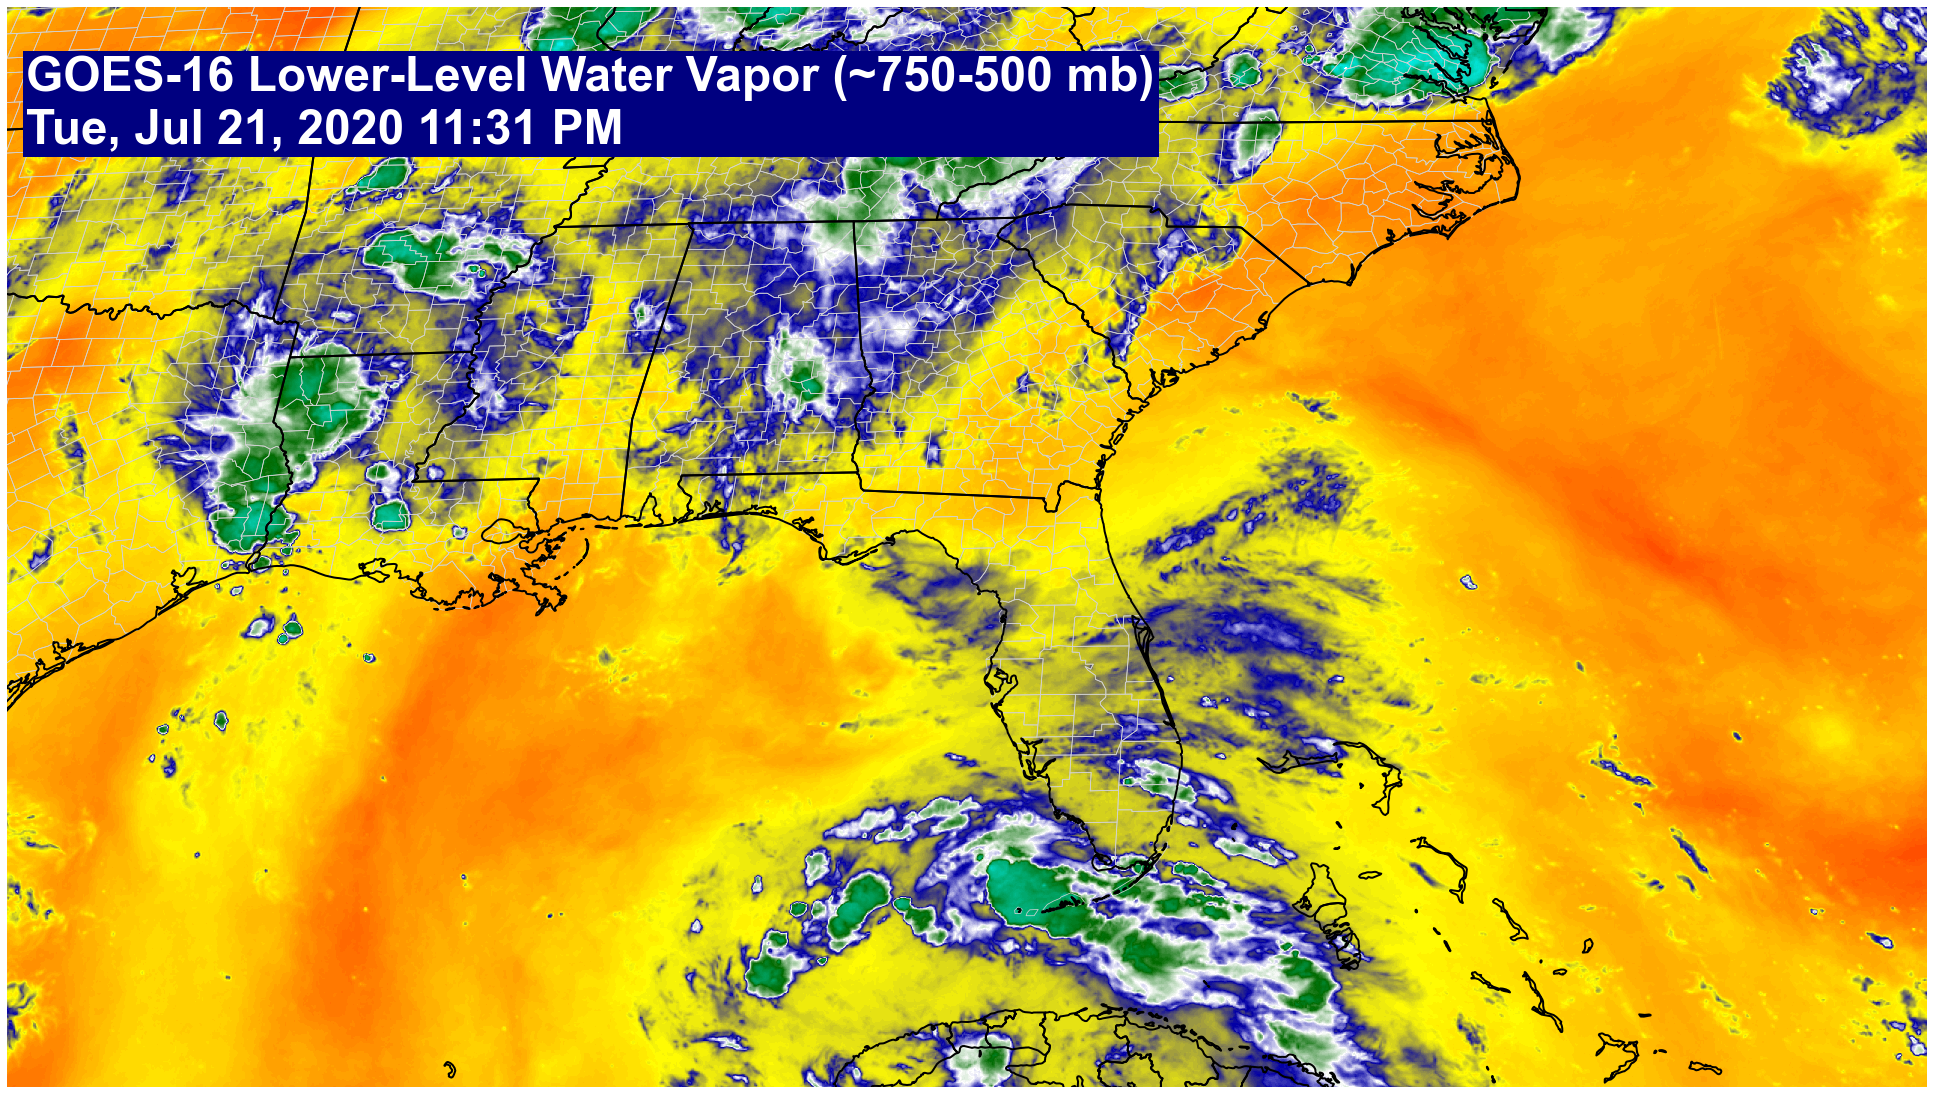

In [6]:
# Build the plot
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=proj)

ax.set_extent([-96.1, -70, 23.2, 37.5])

norm, cmap = registry.get_with_range('WVCIMSS_r', 200, 270)

ax.add_feature(cfeature.OCEAN.with_scale('50m'), color='lightgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.0)
ax.set_adjustable('datalim')
ax.outline_patch.set_visible(False)

im = ax.imshow(data, extent=(x.min(), x.max(), y.min(), y.max()),
               origin='upper')

im.set_cmap(cmap)
im.set_norm(norm)

# Make the axis title
ax.set_title(f'GOES-16 Lower-Level Water Vapor (~750-500 mb)\n{VALID_TIME}', loc='left', 
             ha='left', va='top', fontsize=48, fontname='Arial',
             color='white', fontweight='bold', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Save and show figure
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'satellite'
plt.savefig(f'{graphics_dir}/wv_lower.png', dpi=72)
plt.show()